In [190]:
import os
import sys
import time
import joblib
import tensorflow as tf
from termcolor import cprint
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('.')
sys.path.append('..')

In [2]:
from train_dynamics import *
from train_utils import *

importing libraries


In [3]:
from models.rho_reg_ECCO import ECCONetwork


model = ECCONetwork(radius_scale = 40,
                    layer_channels = [8, 16, 16, 16, 3],
                    encoder_hidden_size=21)

In [4]:
! ls ..

argo_ecco_2.pth		dyna_south.pth			 ped_dyna_32.pth
argo_ecco.pth		evalmod.txt			 ped_ecco.pth
checkpoints		eval.sh				 README.md
commands.md		lstm_logs			 results
cstconv_ped_nll.pth	models				 runs
ctsconv_argo.pth	new_ped_dyna.pth		 saved_models
datasets		pecco_dyna_argo_32_continue.pth  scripts
dyna_south_batch32.pth	pecco_dyna_argo_32.pth		 traindyna.sh
dyna_south_batch36.pth	ped_dyna_32_continue.pth	 trainped.sh


In [200]:
print('loading model')
torch.cuda.set_device(2) 
model_ = torch.load( '../pecco_dyna_argo_32_continue.pth')
model = model_

loading model


In [201]:
device = 'cuda:2'
model.to(device)

ECCONetwork(
  (conv_fluid): EquiCtsConv2dRho1ToReg()
  (conv_obstacle): EquiCtsConv2dRho1ToReg()
  (dense_fluid): Sequential(
    (0): EquiLinearRho1ToReg()
    (1): EquiLinearRegToReg()
  )
  (convs): ModuleList(
    (0): EquiCtsConv2dRegToReg()
    (1): EquiCtsConv2dRegToReg()
    (2): EquiCtsConv2dRegToReg()
    (3): EquiCtsConv2dRegToRho1()
  )
  (denses): ModuleList(
    (0): EquiLinearRegToReg()
    (1): EquiLinearRegToReg()
    (2): EquiLinearRegToReg()
    (3): Sequential(
      (0): EquiLinearRegToReg()
      (1): EquiLinearRegToRho1()
    )
  )
)

In [7]:
val_dataset = read_pkl_data('../../argoverse/val', batch_size=1, shuffle=False, repeat=False)

In [8]:
from torch.profiler import profile, record_function, ProfilerActivity


In [144]:
def predict(sample, model, device):

    data = process_batch(sample, device)
    del sample
    with torch.no_grad():
        lane = data['lane']
        lane_normals = data['lane_norm']
        agent_id = data['agent_id']
        city = data['city']
        scenes = data['scene_idx']

        sigmas = []
        pred = []
        gt = []

        m0 = -10*torch.eye(2, device=device).reshape((1,2,2)).repeat((data['pos0'].shape[0], 60, 1, 1))
        sigma0 = calc_sigma(m0)

        inputs = ([
            data['pos_2s'], data['vel_2s'], 
            data['pos0'], data['vel0'], 
            data['accel'], sigma0,
            data['lane'], data['lane_norm'], 
            data['car_mask'], data['lane_mask']
        ])
        pr_pos1, pr_vel1, pr_m1, states = model(inputs)

        gt_pos1 = data['pos1']

        sigma0 = sigma0 + calc_sigma(pr_m1)

        pr_agent, gt_agent = get_agent(pr_pos1, data['pos1'],
                                       data['track_id0'], 
                                       data['track_id1'], 
                                       agent_id, device, pr_m1=pr_m1)

        sigmas.append(sigma0.unsqueeze(1).detach().cpu())
        pred.append(pr_agent.unsqueeze(1).detach().cpu())
        gt.append(gt_agent.unsqueeze(1).detach().cpu())
        del pr_agent, gt_agent
        clean_cache(device)

        pos0 = data['pos0']
        vel0 = data['vel0']
        for j in tqdm(range(29)):
            pos_enc = torch.unsqueeze(pos0, 2)
            vel_enc = torch.unsqueeze(vel0, 2)
            inputs = (pos_enc, vel_enc, pr_pos1, pr_vel1, data['accel'],
                      sigma0, 
                      data['lane'],
                      data['lane_norm'], data['car_mask'], data['lane_mask'])

            pos0, vel0 = pr_pos1, pr_vel1

            pr_pos1, pr_vel1, pr_m1, states = model(inputs, states)
            clean_cache(device)

            gt_pos1 = data['pos'+str(j+2)]

            sigma0 = sigma0 + calc_sigma(pr_m1)

            pr_agent, gt_agent = get_agent(pr_pos1, data['pos'+str(j+2)],
                                           data['track_id0'],
                                           data['track_id'+str(j+1)],
                                           agent_id, device, pr_m1=sigma0)

            sigmas.append(sigma0.unsqueeze(1).detach().cpu())
            pred.append(pr_agent.unsqueeze(1).detach().cpu())
            gt.append(gt_agent.unsqueeze(1).detach().cpu())

            del inputs, pos_enc, vel_enc, pr_m1
            torch.cuda.empty_cache()
            clean_cache(device)

        predict_result = (torch.cat(pred, axis=1), torch.cat(gt, axis=1), torch.cat(sigmas,axis=1))

        return predict_result


  0%|                                                                                                                             | 0/29 [00:00<?, ?it/s]

predicting sample  [10069]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 15.87it/s]
/home/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: covariance is not symmetric positive-semidefinite.
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


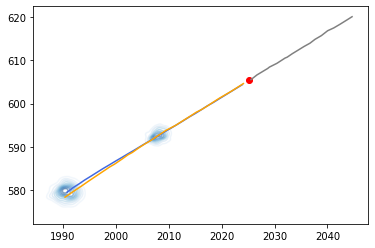

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 17.13it/s]
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: covariance is not symmetric positive-semidefinite.
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(0.0925)
tensor(1.3028)


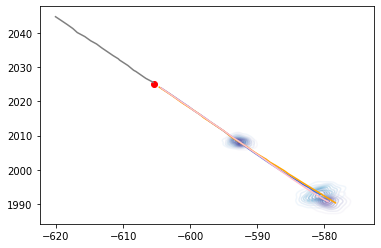

 10%|████████████                                                                                                         | 3/29 [00:00<00:01, 20.51it/s]

predicting sample  [1007]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 19.09it/s]
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


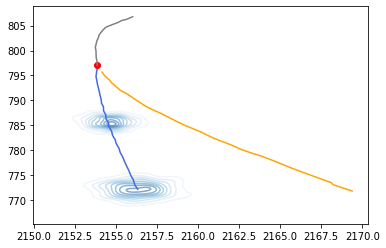

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.87it/s]
/home/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: covariance is not symmetric positive-semidefinite.
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(0.3215)
tensor(4.1945)


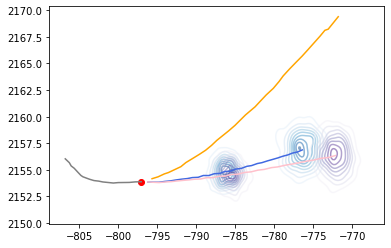

  7%|████████                                                                                                             | 2/29 [00:00<00:01, 19.01it/s]

predicting sample  [10070]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.23it/s]
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


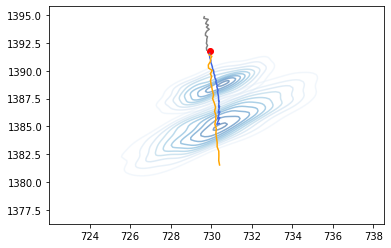

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 13.99it/s]
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(1.1117)
tensor(4.5321)


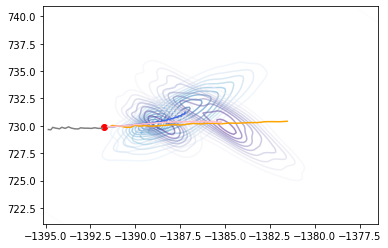

 10%|████████████                                                                                                         | 3/29 [00:00<00:01, 19.98it/s]

predicting sample  [10071]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.97it/s]
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


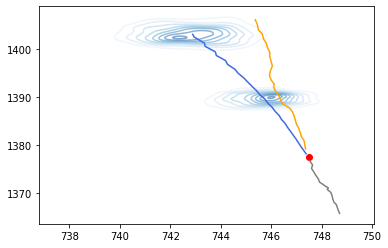

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.18it/s]
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(0.0300)
tensor(0.3349)


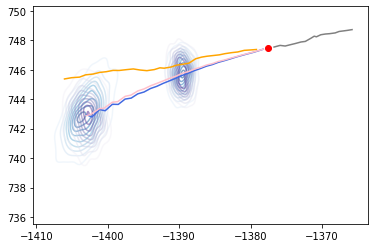

  7%|████████                                                                                                             | 2/29 [00:00<00:01, 17.40it/s]

predicting sample  [10072]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 15.24it/s]
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


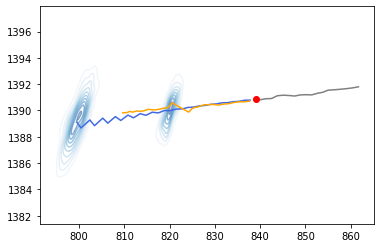

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 16.28it/s]
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(1.8116)
tensor(7.4535)


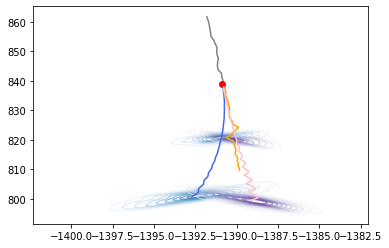

  7%|████████                                                                                                             | 2/29 [00:00<00:01, 15.97it/s]

predicting sample  [10073]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 15.40it/s]
/home/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: covariance is not symmetric positive-semidefinite.
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


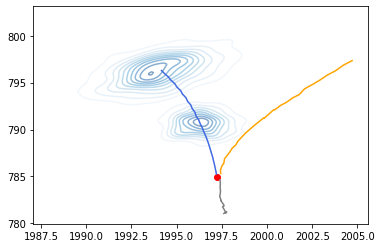

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 14.95it/s]
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: covariance is not symmetric positive-semidefinite.
/home/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: covariance is not symmetric positive-semidefinite.
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(0.0330)
tensor(0.4895)


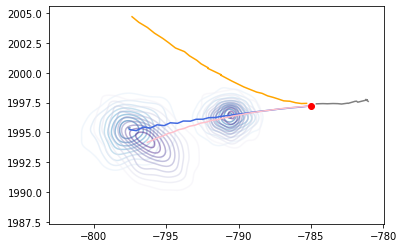

In [230]:
count = 0 
for i, sample in enumerate(val_dataset):
    print('predicting sample ', sample['scene_idx'])

    result = predict(sample, model, device)
    trackid = np.expand_dims(sample['track_id0'][0], -1)
    agent = (trackid == sample['agent_id']).nonzero()[0][0]
    

    plt.plot(sample['pos_2s'][0][agent,:,0], sample['pos_2s'][0][agent,:,1], color='grey')
    plt.scatter(sample['pos0'][0][agent,0], sample['pos0'][0][agent,1], color='red')

    plt.plot(result[0][0,:,0], result[0][0,:,1], color='royalblue')
    plt.plot(result[1][0,:,0], result[1][0,:,1], color = 'orange')
    
    for i in [14,29]:
        samples = np.random.multivariate_normal([result[0][0,i,0], result[0][0,i,1]], result[0][0,i,2:].reshape(2,2), size=600)
        sns.kdeplot(data=samples, cmap="Blues", shade=False, alpha=0.5) 
    plt.show()

    
    # roation
    
    rotate_sample = rotate(sample, 0.5* np.pi)
    
    rotate_result = predict(rotate_sample, model, device)
    plt.plot(sample['pos_2s'][0][agent,:,0], sample['pos_2s'][0][agent,:,1], color='grey')
    plt.scatter(sample['pos0'][0][agent,0], sample['pos0'][0][agent,1], color='red')
    plt.plot(rotate_result[0][0,:,0], rotate_result[0][0,:,1], color='royalblue')
    plt.plot(rotate_result[1][0,:,0], rotate_result[1][0,:,1], color = 'orange')
    for i in [14,29]:
        samples = np.random.multivariate_normal([rotate_result[0][0,i,0], rotate_result[0][0,i,1]], rotate_result[0][0,i,2:].reshape(2,2), size=600)
        sns.kdeplot(data=samples, cmap="Blues", shade=False, alpha=0.5) 
    
    # rotated prev results

    rotate_xy, rotate_cov = rotate_pred(result[0],0.5* np.pi)
    plt.plot(rotate_xy[0,:,0], rotate_xy[0,:,1], color = 'pink')
    for i in [14,29]:
        samples = np.random.multivariate_normal([rotate_xy[0,i,0], rotate_xy[0,i,1]], rotate_cov[0,i,:,:], size=600)
        sns.kdeplot(data=samples, cmap="Purples", shade=False, alpha=0.5)
        p = torch.distributions.MultivariateNormal(rotate_result[0][0,i,:2],rotate_result[0][0,i,2:].reshape(2,2))
        q = torch.distributions.MultivariateNormal(rotate_xy[0,i,:],rotate_cov[0,i,:,:])
        kl = torch.distributions.kl.kl_divergence(p, q)
        print(kl)


    
    plt.show()
   
    
    count += 1
    if count >5:
        break


In [219]:
def RotMat(theta):
    m = np.array([
            [np.cos(theta), -np.sin(theta)], 
            [np.sin(theta), np.cos(theta)]
        ])
    return m

def rotation(theta, field):
    rotmat = RotMat(theta)
    rot_field = np.zeros(field.shape)
    rot_field[...,:2] =  np.einsum('ij,...j->...i', rotmat, field[...,:2])
    if field.shape[-1] > 2:
        rot_field[...,2] = 0
    return rot_field

def rotate(data, theta):
    convert_keys = (['pos' + str(i) for i in range(31)] + 
                    ['vel' + str(i) for i in range(31)] + 
                    ['pos_2s', 'vel_2s', 'lane', 'lane_norm'])

    for k in convert_keys:
        #print(k, data[k])
        data[k] = [rotation(theta, data[k][0])]
    return data


def rotate_pred(data, theta):
    xy = data[:,:,:2]
    cov = data[:,:,-4:].reshape(*data.shape[:2],2,2)
    
    new_xy =  torch.tensor(rotation(theta, xy), dtype=torch.float32) 
    rot = torch.tensor(RotMat(theta), dtype=torch.float32) 
    new_cov = torch.matmul(torch.matmul(rot, cov), rot.T)
    return new_xy, new_cov
    

# CtsConv

In [207]:
from models.cstcov import ParticlesNetwork

ctscov = ParticlesNetwork()
ctscov_model = torch.load('../ctsconv_argo' + '.pth')
device = 'cuda:2'
ctscov_model.to(device)

ParticlesNetwork(
  (conv_fluid): CtsConv(input_channels=66, output_channels=32, kernel_size=[4, 4, 4])
  (conv_obstacle): CtsConv(input_channels=3, output_channels=32, kernel_size=[4, 4, 4])
  (dense_fluid): Linear(in_features=66, out_features=32, bias=True)
  (convs): ModuleList(
    (0): CtsConv(input_channels=96, output_channels=64, kernel_size=[4, 4, 4])
    (1): CtsConv(input_channels=64, output_channels=64, kernel_size=[4, 4, 4])
    (2): CtsConv(input_channels=64, output_channels=64, kernel_size=[4, 4, 4])
    (3): CtsConv(input_channels=64, output_channels=6, kernel_size=[4, 4, 4])
  )
  (denses): ModuleList(
    (0): Linear(in_features=96, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [226]:
def predict_ctscov(sample, model, device):

    data = process_batch(sample, device)
    del sample
    
    pred = []
    gt = []
    with torch.no_grad():

        pos_zero = torch.unsqueeze(torch.zeros(data['pos0'].shape[:-1], device=device),-1)
        data['pos0'] = torch.cat([data['pos0'], pos_zero], dim = -1)
        data['vel0'] = torch.cat([data['vel0'], pos_zero], dim = -1)

        lane_zero = torch.zeros(data['pos0'].shape[0], 650, 1, device=device)
        data['lane'] = torch.cat([data['lane'], lane_zero], dim = -1)
        data['lane_norm'] = torch.cat([data['lane_norm'], lane_zero], dim = -1)

        data['accel'] = torch.cat([data['accel'], torch.zeros(data['accel'].shape[:-1],device=device).unsqueeze(-1)], dim = -1)
        zero_2s = torch.unsqueeze(torch.zeros(data['vel_2s'].shape[:-1], device=device),-1)
        data['vel_2s'] = torch.cat([data['vel_2s'], zero_2s], dim = -1)

        
        lane = data['lane']
        lane_normals = data['lane_norm']
        agent_id = data['agent_id']
        city = data['city']
        scenes = data['scene_idx']

        inputs = ([
            data['pos_2s'], data['vel_2s'], 
            data['pos0'], data['vel0'], 
            data['accel'], data['sigmas'],
            data['lane'], data['lane_norm'], 
            data['car_mask'], data['lane_mask']
        ])
        

        pr_pos1, pr_vel1, pr_m1, states = model(inputs)

        gt_pos1 = data['pos1']
        

        pr_agent, gt_agent = get_agent(pr_pos1, data['pos1'],
                                       data['track_id0'], 
                                       data['track_id1'], 
                                       agent_id, device, pr_m1=pr_m1)
        
        pred.append(pr_agent.unsqueeze(1).detach().cpu())
        gt.append(gt_agent.unsqueeze(1).detach().cpu())
        del pr_agent, gt_agent
        clean_cache(device)

        pos0 = data['pos0']
        vel0 = data['vel0']
        m0 = torch.zeros((data['pos0'].shape[0], 60, 2, 2), device=device)
        for j in range(29):
            pos_enc = torch.unsqueeze(pos0, 2)
            vel_enc = torch.unsqueeze(vel0, 2)

            inputs = (pos_enc, vel_enc, pr_pos1, pr_vel1, data['accel'],
                      torch.cat([m0, pr_m1], dim=-2), 
                      data['lane'],
                      data['lane_norm'], data['car_mask'], data['lane_mask'])

            pos0, vel0, m0 = pr_pos1, pr_vel1, pr_m1

            pr_pos1, pr_vel1, pr_m1, states = model(inputs, states)
            clean_cache(device)
            

            gt_pos1 = data['pos'+str(j+2)]
            pr_agent, gt_agent = get_agent(pr_pos1, data['pos'+str(j+2)],
                                           data['track_id0'],
                                           data['track_id'+str(j+1)],
                                           agent_id, device, pr_m1=pr_m1)

            pred.append(pr_agent.unsqueeze(1).detach().cpu())
            gt.append(gt_agent.unsqueeze(1).detach().cpu())
            
            clean_cache(device)

        predict_result = (torch.cat(pred, axis=1), torch.cat(gt, axis=1))
        return predict_result

predicting sample  [10083]


/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(0.1271)
tensor(10.4866)


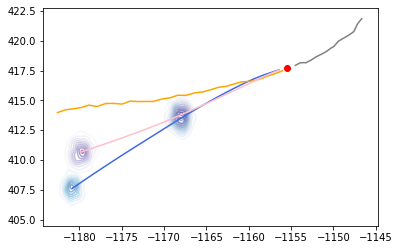

predicting sample  [10084]


/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(3.4054)
tensor(39.4728)


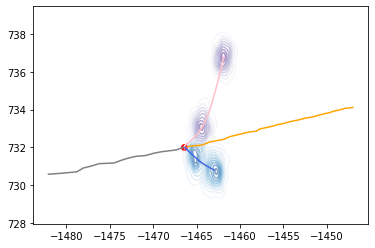

predicting sample  [10085]


/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(33.4228)
tensor(228.6665)


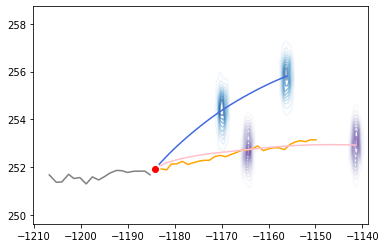

predicting sample  [10086]


/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(2.2319)
tensor(14.7006)


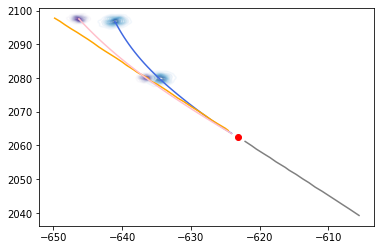

predicting sample  [10087]


/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(139.4292)
tensor(703.3682)


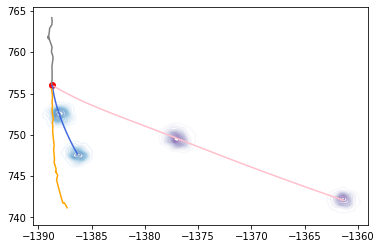

predicting sample  [10088]


/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(167.6661)
tensor(944.6220)


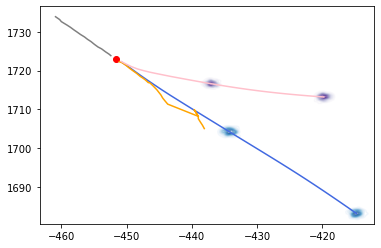

predicting sample  [10089]


/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(2.2374)
tensor(42.9917)


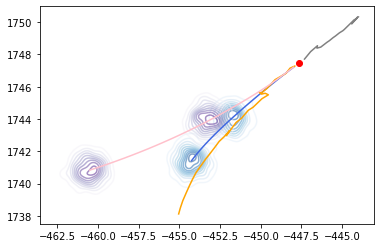

predicting sample  [1009]


/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(26.1399)
tensor(398.9588)


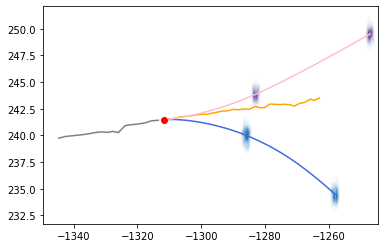

predicting sample  [10090]


/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(19.4266)
tensor(208.7264)


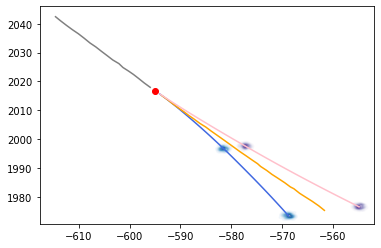

predicting sample  [10091]


/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(1.7785)
tensor(17.2257)


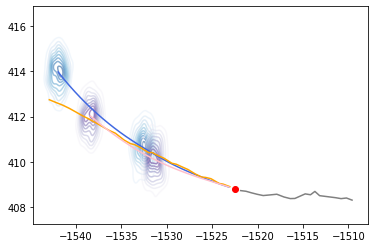

predicting sample  [10092]


/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/user/.local/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


tensor(7.6816)
tensor(123.6908)


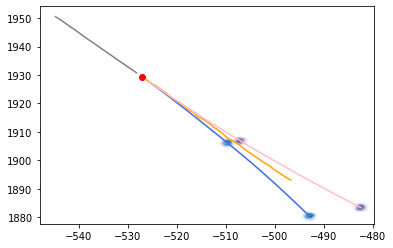

In [235]:
count = 0 
for i, sample in enumerate(val_dataset):
    print('predicting sample ', sample['scene_idx'])

    result = predict_ctscov(sample, ctscov_model, device)
    trackid = np.expand_dims(sample['track_id0'][0], -1)
    agent = (trackid == sample['agent_id']).nonzero()[0][0]
    
    '''
    plt.plot(sample['pos_2s'][0][agent,:,0], sample['pos_2s'][0][agent,:,1], color='grey')
    plt.scatter(sample['pos0'][0][agent,0], sample['pos0'][0][agent,1], color='red')

    plt.plot(result[0][0,:,0], result[0][0,:,1], color='royalblue')
    plt.plot(result[1][0,:,0], result[1][0,:,1], color = 'orange')
    
    for i in [14,29]:
        samples = np.random.multivariate_normal([result[0][0,i,0], result[0][0,i,1]], result[0][0,i,3:].reshape(2,2), size=600)
        sns.kdeplot(data=samples, cmap="Blues", shade=False, alpha=0.5) 
    plt.show()
    '''

    # roation
    
    rotate_sample = rotate(sample, 0.5* np.pi)
    
    rotate_result = predict_ctscov(rotate_sample, ctscov_model, device)
    plt.plot(sample['pos_2s'][0][agent,:,0], sample['pos_2s'][0][agent,:,1], color='grey')
    plt.scatter(sample['pos0'][0][agent,0], sample['pos0'][0][agent,1], color='red')
    plt.plot(rotate_result[0][0,:,0], rotate_result[0][0,:,1], color='royalblue')
    plt.plot(rotate_result[1][0,:,0], rotate_result[1][0,:,1], color = 'orange')
    for i in [14,29]:
        sigma = calc_sigma(rotate_result[0][0,i,-4:].reshape(2,2))

        samples = np.random.multivariate_normal([rotate_result[0][0,i,0], rotate_result[0][0,i,1]], sigma, size=600)
        sns.kdeplot(data=samples, cmap="Blues", shade=False, alpha=0.5) 
    
    # rotated prev results

    rotate_xy, rotate_cov = rotate_pred(result[0],0.5* np.pi)
    plt.plot(rotate_xy[0,:,0], rotate_xy[0,:,1], color = 'pink')
    for i in [14,29]:
        sigma = calc_sigma(rotate_cov[0,i,:,:])
        samples = np.random.multivariate_normal([rotate_xy[0,i,0], rotate_xy[0,i,1]], sigma, size=600)
        sns.kdeplot(data=samples, cmap="Purples", shade=False, alpha=0.5)
        sigma1 = calc_sigma(rotate_result[0][0,i,-4:].reshape(2,2))
        p = torch.distributions.MultivariateNormal(rotate_result[0][0,i,:2],sigma)
        q = torch.distributions.MultivariateNormal(rotate_xy[0,i,:],sigma1)
        kl = torch.distributions.kl.kl_divergence(p, q)
        print(kl)

    
    plt.show()

    count += 1
    if count >10:
        break


In [240]:
!pip install --upgrade torch

  Using cached torch-1.10.1-cp37-cp37m-manylinux1_x86_64.whl (881.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.8.1
    Uninstalling torch-1.8.1:
      Successfully uninstalled torch-1.8.1


In [21]:
!nvidia-smi

Thu Jan 13 14:43:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 27%   45C    P2    61W / 250W |   4856MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 22%   